In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import matplotlib.pyplot as plt

In [21]:
tx_merge = pd.read_csv('../data/tx_merge_clustered.csv')
print("Loaded columns:", tx_merge.columns.tolist())

Loaded columns: ['Recency', 'Frequency', 'Revenue', 'Revenue_per_Transaction', 'm6_Revenue', 'CustomerID', 'LTVCluster']


In [27]:
X = tx_merge[['Recency', 'Revenue', 'Revenue_per_Transaction']]
y = tx_merge['LTVCluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Original y_train distribution:")
print(y_train.value_counts())

Original y_train distribution:
LTVCluster
0    2043
1     433
2      70
Name: count, dtype: int64


In [28]:
original_counts = y_train.value_counts()
smote = SMOTE(
    sampling_strategy={0: max(2000, original_counts[0]), 1: 1200, 2: 300},
    random_state=42,
    k_neighbors=3
)
X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)
print("Post-SMOTE y_train distribution:")
print(pd.Series(y_train).value_counts())

Post-SMOTE y_train distribution:
LTVCluster
0    2043
1    1200
2     300
Name: count, dtype: int64


In [29]:
xgb_model = xgb.XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.03,
    scale_pos_weight=4,
    gamma=2,
    min_child_weight=5,
    random_state=42,
    eval_metric='mlogloss'
)
xgb_model.fit(X_train_scaled, y_train)

C:\Users\mehta\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [21:42:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=2,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None,
              num_parallel_tree=None, ...)

In [31]:
y_pred_proba = xgb_model.predict_proba(X_test_scaled)
threshold = 0.9 
y_pred_test = np.argmax(y_pred_proba, axis=1)
for i in range(len(y_pred_test)):
    if y_pred_proba[i, 2] > threshold:  
        y_pred_test[i] = 2

print("\nXGBoost Results:")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_test):.2f}")
print("\nClass Metrics (Precision | Recall | F1):")
report = classification_report(y_test, y_pred_test, target_names=['Low', 'Mid', 'High'], output_dict=True)
for cls in ['Low', 'Mid', 'High']:
    print(f"{cls}: {report[cls]['precision']:.2f} | {report[cls]['recall']:.2f} | {report[cls]['f1-score']:.2f}")


XGBoost Results:
Test Accuracy: 0.84

Class Metrics (Precision | Recall | F1):
Low: 0.94 | 0.87 | 0.90
Mid: 0.53 | 0.71 | 0.61
High: 0.50 | 0.50 | 0.50


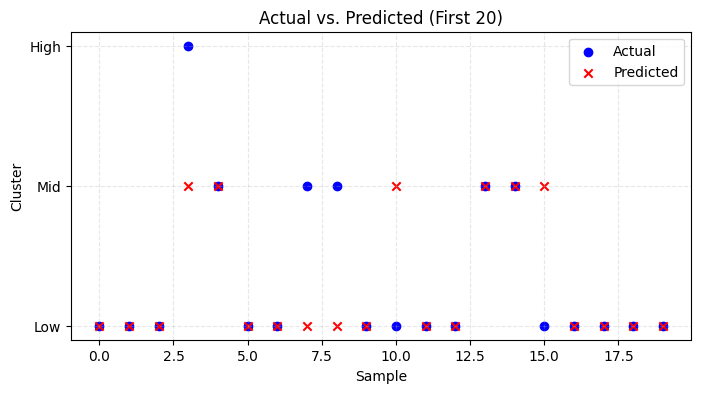

In [32]:
plt.figure(figsize=(8, 4))
plt.scatter(range(20), y_test.values[:20], color='blue', label='Actual', marker='o')
plt.scatter(range(20), y_pred_test[:20], color='red', label='Predicted', marker='x')
plt.yticks([0, 1, 2], ['Low', 'Mid', 'High'])
plt.xlabel('Sample')
plt.ylabel('Cluster')
plt.title('Actual vs. Predicted (First 20)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [36]:
import joblib

joblib.dump(xgb_model, '../models/xgb_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')

['../models/scaler.pkl']

In [37]:
loaded_model = joblib.load('../models/xgb_model.pkl')
loaded_scaler = joblib.load('../models/scaler.pkl')

new_data = pd.DataFrame({
    'Recency': [10, 50, 100],
    'Revenue': [500, 2000, 10000],
    'Revenue_per_Transaction': [50, 100, 200]
})
new_data_scaled = loaded_scaler.transform(new_data)
new_pred_proba = loaded_model.predict_proba(new_data_scaled)
new_pred = np.argmax(new_pred_proba, axis=1)
for i in range(len(new_pred)):
    if new_pred_proba[i, 2] > 0.85: 
        new_pred[i] = 2

print("Predictions for new data:", new_pred)

Predictions for new data: [0 1 0]
